# Prophecy of Properties: Exploring The Housing Market in Cook County

<hr style="border: 1px solid #fdb515;" />
<hr style="border: 5px solid #003262;" />

## Introduction

#### This project follows the Data Science Lifecycle as it explores what can be learned from an extensive housing dataset that is embedded in a dense social context in Cook County, Illinois.

##### Import Statements

In [1]:
import numpy as np

import pandas as pd

%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns

import warnings
warnings.filterwarnings("ignore")

import zipfile
import os

# Plot settings
plt.rcParams['figure.figsize'] = (12, 9)
plt.rcParams['font.size'] = 12

<br/><br/>
<hr style="border: 5px solid #003262;" />
<hr style="border: 1px solid #fdb515;" />

# The Housing Data

The dataset consists of over 500,000 records from Cook County, Illinois, the county where Chicago is located. The dataset has 61 features in total; the 62nd is `Sale Price`, which we will try and predict with Ordinary Least Squares regression. An explanation of each variable can be found in the included `codebook.txt` file (you can optionally open this by first clicking the `data` folder, then clicking `codebook.txt` file in the navigation pane).

I have split the data into training and testing sets with 204,792 and 68,264 observations, respectively.

Let's first extract the data from the `cook_county_data.zip`. I decided to not leave the `csv` files directly in the directory because they take up too much space without some prior compression.

In [2]:
with zipfile.ZipFile('data/cook_county_data.zip') as item:
    item.extractall()

Let's load the initial data.

In [3]:
initial_data = pd.read_csv("cook_county_train.csv", index_col='Unnamed: 0')

As a good sanity check, we should at least verify that the data shape matches the description.

In [4]:
# 204,792 observations and 62 features in training data
assert initial_data.shape == (204792, 62)
# Sale Price is provided in the training data
assert 'Sale Price' in initial_data.columns.values

##### No Errors means we're good to go!

Let's try and get a feel for the variables in our data.  A more detailed description of each variable is included in `codebook.txt`

Let's take a quick look at all the current columns in our initial data.

In [5]:
initial_data.columns.values

array(['PIN', 'Property Class', 'Neighborhood Code', 'Land Square Feet',
       'Town Code', 'Apartments', 'Wall Material', 'Roof Material',
       'Basement', 'Basement Finish', 'Central Heating', 'Other Heating',
       'Central Air', 'Fireplaces', 'Attic Type', 'Attic Finish',
       'Design Plan', 'Cathedral Ceiling', 'Construction Quality',
       'Site Desirability', 'Garage 1 Size', 'Garage 1 Material',
       'Garage 1 Attachment', 'Garage 1 Area', 'Garage 2 Size',
       'Garage 2 Material', 'Garage 2 Attachment', 'Garage 2 Area',
       'Porch', 'Other Improvements', 'Building Square Feet',
       'Repair Condition', 'Multi Code', 'Number of Commercial Units',
       'Estimate (Land)', 'Estimate (Building)', 'Deed No.', 'Sale Price',
       'Longitude', 'Latitude', 'Census Tract',
       'Multi Property Indicator', 'Modeling Group', 'Age', 'Use',
       "O'Hare Noise", 'Floodplain', 'Road Proximity', 'Sale Year',
       'Sale Quarter', 'Sale Half-Year', 'Sale Quarter of Year'

This is the first entry in the `Description` Column:

In [6]:
initial_data['Description'][0]

'This property, sold on 09/14/2015, is a one-story houeshold located at 2950 S LYMAN ST.It has a total of 6 rooms, 3 of which are bedrooms, and 1.0 of which are bathrooms.'

<br/><br/>
<hr style="border: 1px solid #fdb515;" />

# Contextualizing the Data
Let's consider the background of our dataset before diving into a full-scale analysis. 

<!-- BEGIN QUESTION -->

### 1) Granuarity of the Data (i.e. What does each row represent?)

Each row represents the sale of one house. Specifically, the sale of a house in Cook County, where our data is from. 


<!-- END QUESTION -->

<!-- BEGIN QUESTION -->

---
### 2) What are some possible explanations for why this data was collected? What purposes could they serve? Who collected it?

This data could just be financial records of all the houses, and could have been used to keep track of current market rates for the sale of houses in certain locations. The data could also have been collected in order to keep track of financial records, so for any house, you could see how its value changed throughout time. 

<!-- END QUESTION -->

<!-- BEGIN QUESTION -->

---
### 3) Given this data, what are some initial questions we could go about answering?

##### "How has the average price of each house changed throughout time?" 
* We could make a line plot which time on the X axis, and the mean price on the y axis, using column of `Sale Price`. 

* One other thing we could do is a create a heatmap of the cook county area, and see how the mean `Sale Price` price differs for certain neighborhoods. We could do something with geopandas in that case.

* The specific column we would work with would probably be the `Neighborhood` code. If we had more data on what the latitudes and longitudes of each code was, then we would be able to answer this question.

<!-- END QUESTION -->

<hr style="border: 1px solid #fdb515;" />

# Exploratory Data Analysis

This dataset was collected by the [Cook County Assessor's Office](https://datacatalog.cookcountyil.gov/Property-Taxation/Archive-Cook-County-Assessor-s-Residential-Sales-D/5pge-nu6u) in order to build a model to predict the monetary value of a home. 

For simplicity, we will perform EDA on the **initial data**.

### Sale Price
We begin by examining the distribution of our target variable `Sale Price`. We defined the helper method `plot_distribution` to make it easier to visualize the distribution of the `Sale Price` using both a histogram and box plot at the same time.

In [7]:
def plot_distribution(data, label):
    fig, axs = plt.subplots(nrows=2)

    sns.distplot(
        data[label], 
        ax=axs[0]
    )
    sns.boxplot(
        x=data[label],
        width=0.3, 
        ax=axs[1],
        showfliers=False,
    )

    # Align axes
    spacer = np.max(data[label]) * 0.05
    xmin = np.min(data[label]) - spacer
    xmax = np.max(data[label]) + spacer
    axs[0].set_xlim((xmin, xmax))
    axs[1].set_xlim((xmin, xmax))

    # Remove some axis text
    axs[0].xaxis.set_visible(False)
    axs[0].yaxis.set_visible(False)
    axs[1].yaxis.set_visible(False)

    # Put the two plots together
    plt.subplots_adjust(hspace=0)
    fig.suptitle("Distribution of " + label)

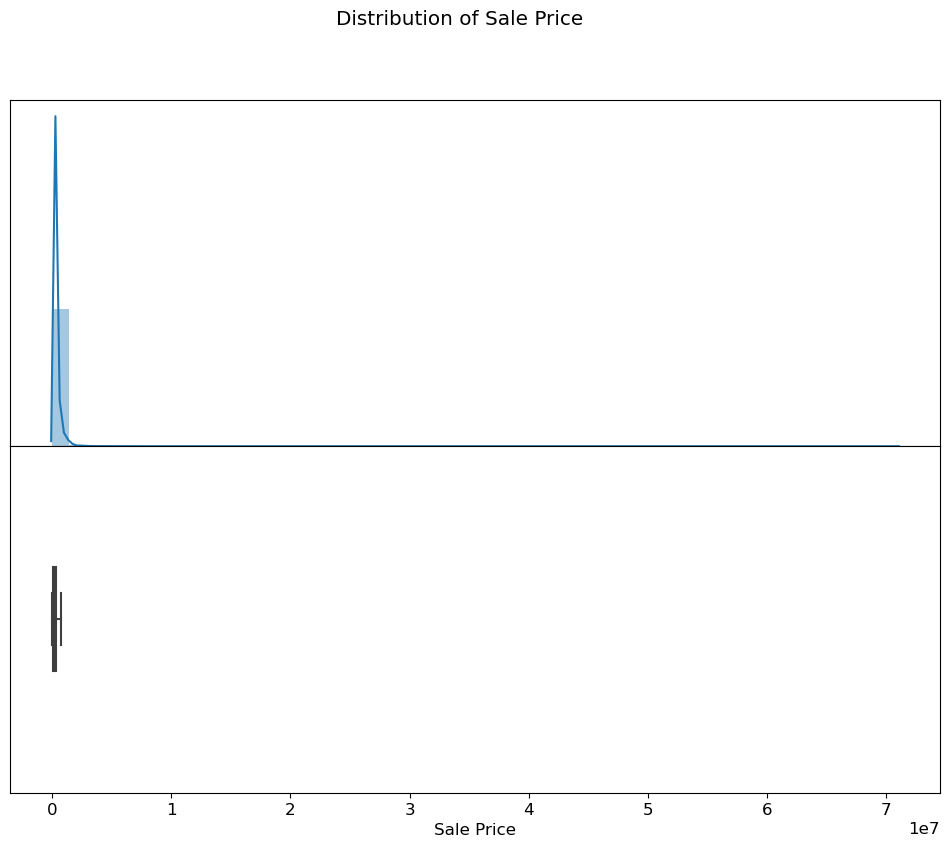

In [8]:
plot_distribution(initial_data, label='Sale Price')

At the same time, we also take a look at some descriptive statistics of this variable. Run the following cell.

In [9]:
initial_data['Sale Price'].describe()

count    2.047920e+05
mean     2.451646e+05
std      3.628694e+05
min      1.000000e+00
25%      4.520000e+04
50%      1.750000e+05
75%      3.120000e+05
max      7.100000e+07
Name: Sale Price, dtype: float64

<!-- BEGIN QUESTION -->

Using both the plots and the statistics from `initial_data['Sale Price'].describe()`, we run into the following issue: 

* Most of our data seems to be clustered around a very small area, while the presence of very large outliers skew our whole graph. 

* Thus, the scaling is off. 
* Since these large outliers are so big, but their abundance is so little, it's hard to see the distribution of the data which is of the **majority**. 
* It's almost impossible to see the true distribution of most of our data. 
* In order to combat this, we could scale all of our datapoints so that the outliers are much closer to the rest of our data. 
* One process could be taking the log of each datapoint, thus making the large values align more with the others. 

<br><br>

---

To zoom in on the visualization of most households, we will focus only on a subset of `Sale Price`. In addition, it may be a good idea to apply a log transformation to `Sale Price`. In the cell below, we assigned `training_data` to a new `DataFrame` that is the same as `initial_data` **except with the following changes**:

- `training_data` contains only households whose price is at least $500.
- `training_data` contains a new `Log Sale Price` column that contains the log-transformed sale prices.

**Note**: This also implies from now on, our target variable in the model will be the log-transformed sale prices from the column `Log Sale Price`. 

In [10]:
at_least_500 = initial_data[initial_data["Sale Price"] >= 500] 
log_transformed = np.log(at_least_500["Sale Price"])
training_data = at_least_500
training_data["Log Sale Price"] = log_transformed
training_data.head()

,PIN,Property Class,Neighborhood Code,Land Square Feet,Town Code,Apartments,Wall Material,Roof Material,Basement,Basement Finish,...,Sale Half of Year,Most Recent Sale,Age Decade,Pure Market Filter,Garage Indicator,Neigborhood Code (mapping),Town and Neighborhood,Description,Lot Size,Log Sale Price
1,13272240180000,202,120,3780.0,71,0.0,2.0,1.0,1.0,1.0,...,1,1.0,9.6,1,1.0,120,71120,"This property, sold on 05/23/2018, is a one-st...",3780.0,12.560244
2,25221150230000,202,210,4375.0,70,0.0,2.0,1.0,2.0,3.0,...,1,0.0,11.2,1,1.0,210,70210,"This property, sold on 02/18/2016, is a one-st...",4375.0,9.998798
3,10251130030000,203,220,4375.0,17,0.0,3.0,1.0,1.0,3.0,...,2,1.0,6.3,1,1.0,220,17220,"This property, sold on 07/23/2013, is a one-st...",4375.0,12.323856
4,31361040550000,202,120,8400.0,32,0.0,3.0,1.0,2.0,3.0,...,1,0.0,6.3,1,1.0,120,32120,"This property, sold on 06/10/2016, is a one-st...",8400.0,10.025705
6,30314240080000,203,181,10890.0,37,0.0,1.0,1.0,1.0,3.0,...,2,1.0,10.9,1,1.0,181,37181,"This property, sold on 10/26/2017, is a one-st...",10890.0,11.512925


Let's create a new distribution plot using the log-transformed sale prices. We observe that the distribution for `Log Scale Price` is much more uniform.

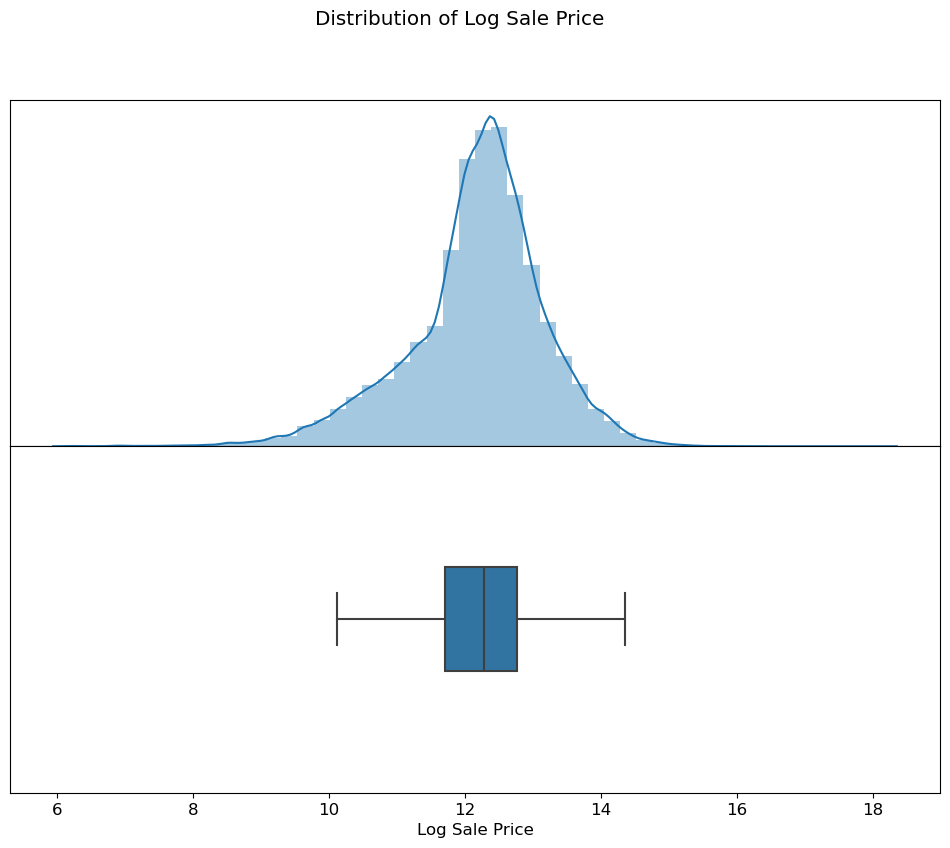

In [11]:
plot_distribution(training_data, label='Log Sale Price');

<br><br>

---

A reasonable question is to ask "Is there any correlation between `Log Sale Price` and the total area occupied by the property?" Referencing `codebook.txt`, it tells us that the column `Building Square Feet` should do the trick — it measures "(from the exterior) the total area, in square feet, occupied by the building".

Let's also apply a log transformation to the `Building Square Feet` column.

In the following cell, we create a new column `Log Building Square Feet` in our `training_data` that contains the log-transformed area occupied by each property. 

In [12]:
training_data['Log Building Square Feet'] = np.log(training_data["Building Square Feet"])

<!-- BEGIN QUESTION -->

<br><br>

---

In the visualization below, we created a `jointplot` with `Log Building Square Feet` on the x-axis, and `Log Sale Price` on the y-axis. In addition, we fit a simple linear regression line through the bivariate scatter plot in the middle.

Based on the following plot, we can see that `Log Building Square Feet` would make a good candidate as one of the features for our model, as there is a fairly strong, linear correlation between `Log Building Square Feet` and `Log Sale Price`


![Joint Plot](images/q2p3_jointplot.png)


<!-- END QUESTION -->

---

To prevent running into into more outliers which prevent us from creating a clear visualization / capturing the trend of the majority of the houses, we wrote a function called `remove_outliers`

`remove_outliers` removes outliers from the dataset based on a threshold value of a variable. For example, `remove_outliers(training_data, 'Building Square Feet', lower=500, upper=8000)` would return a copy of `data` with only observations that satisfy `Building Square Feet` less than or equal to 8000 (inclusive) and `Building Square Feet` greater than 500 (inclusive).

In [13]:
def remove_outliers(data, variable, lower=-np.inf, upper=np.inf):
    """
    Input:
      data (DataFrame): the table to be filtered
      variable (string): the column with numerical outliers
      lower (numeric): observations with values lower than or equal to this will be removed
      upper (numeric): observations with values higher than or equal to this will be removed
    
    Output:
      a DataFrame with outliers removed
      
    Note: This function should not change mutate the contents of data.
    """  
    return data[(data[variable] >= lower) & (data[variable] <= upper)]

<br/><br/>
<hr style="border: 1px solid #fdb515;" />

# Feature Engineering

In this section, we go through a few feature engineering techniques. 

### Bedrooms

Let's start simple by extracting the total number of bedrooms as our first feature for the model. The `Bedrooms` column doesn't actually exist in the original `DataFrame`! Instead, it is part of the `Description` column.

In [14]:
# optional cell for scratch work
for i in np.arange(5):
    print (initial_data["Description"][i])

This property, sold on 09/14/2015, is a one-story houeshold located at 2950 S LYMAN ST.It has a total of 6 rooms, 3 of which are bedrooms, and 1.0 of which are bathrooms.
This property, sold on 05/23/2018, is a one-story houeshold located at 2844 N LOWELL AVE.It has a total of 6 rooms, 3 of which are bedrooms, and 1.0 of which are bathrooms.
This property, sold on 02/18/2016, is a one-story houeshold located at 11415 S PRAIRIE AVE.It has a total of 7 rooms, 3 of which are bedrooms, and 1.0 of which are bathrooms.
This property, sold on 07/23/2013, is a one-story with partially livable attics houeshold located at 2012 DOBSON ST.It has a total of 5 rooms, 3 of which are bedrooms, and 1.5 of which are bathrooms.
This property, sold on 06/10/2016, is a one-story houeshold located at 104 SAUK TRL.It has a total of 5 rooms, 2 of which are bedrooms, and 1.0 of which are bathrooms.


<br><br>

---

We create a `add_total_bedrooms(data)` function that returns a copy of `data` with an additional column called `Bedrooms`, which contains the total number of bedrooms (**as integers**) for each house. We treat missing values as zeros, if necessary.

In [15]:
def add_total_bedrooms(data):
    """
    Input:
      data (DataFrame): a DataFrame containing at least the Description column.

    Output:
      a Dataframe with a new column "Bedrooms" containing ints.

    """
    with_rooms = data.copy()
    pattern = r"(\d+) of which are bedrooms"
    with_rooms["Bedrooms"] = with_rooms["Description"].str.extract(pattern).astype("int")
    return with_rooms

training_data = add_total_bedrooms(training_data)

<!-- BEGIN QUESTION -->

<br><br>

---

Let's now create a visualization that clearly and succinctly shows if there exists an association between  `Bedrooms` and `Log Sale Price`. Ideally, a good visualization should satisfy the following requirements:
- It should avoid overplotting.

- It should have clearly labeled axes and a succinct title.
- It should convey the strength of the correlation between `Sale Price` and the number of rooms: in other words, we should be able to look at the plot and describe the general relationship between `Log Sale Price` and `Bedrooms`.

Let's try plotting a boxplot *for each* discrete value of `Bedrooms`, just so we can get an idea of the variability among each `Bedrooms` value!

Text(0.5, 1.0, 'The Relationship Between Log Sale Price For Each Value Of Bedrooms')

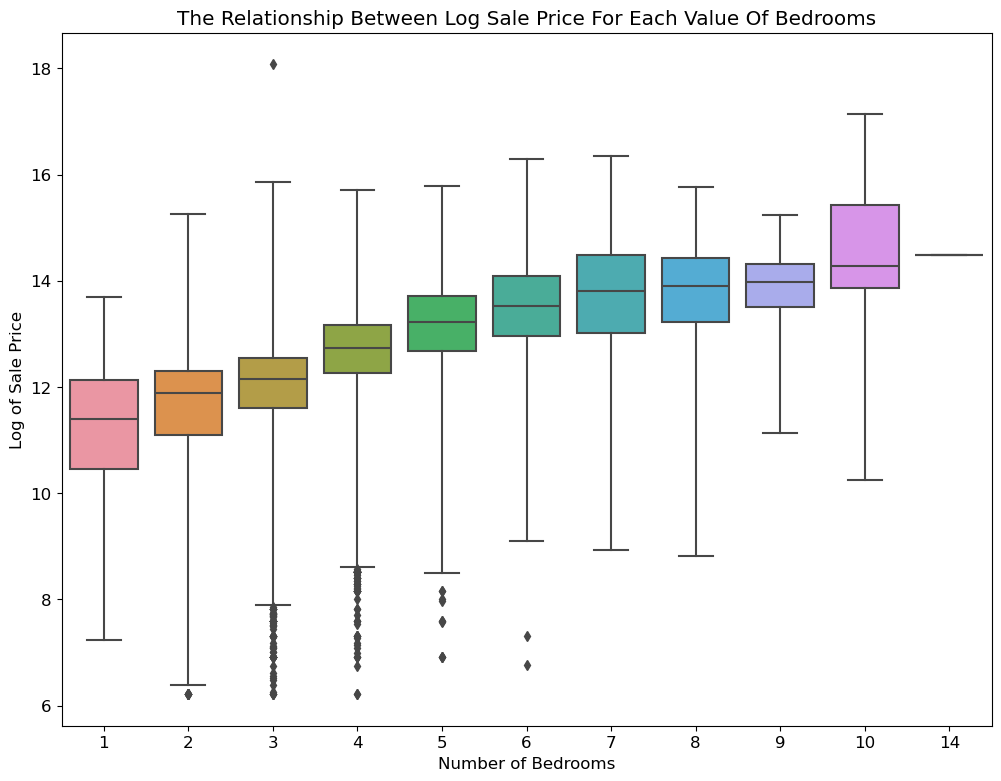

In [16]:
sns.boxplot(x = training_data["Bedrooms"], y = training_data["Log Sale Price"], whis = 4)
plt.xlabel("Number of Bedrooms")
plt.ylabel("Log of Sale Price")
plt.title("The Relationship Between Log Sale Price For Each Value Of Bedrooms")

<!-- END QUESTION -->

Now, let's take a look at the relationship between neighborhood and sale prices of the houses in our dataset.
Notice that currently we don't have the actual names for the neighborhoods. Instead we will use a similar column, `Neighborhood Code` (which is a numerical encoding of the actual neighborhoods by the Assessment office).

<br><br>

---
If we try directly plotting the distribution of `Log Sale Price` for all of the households in each neighborhood using the `plot_categorical` function from the next cell, we get the following visualization.


![overplot](images/q5p2_catplot.png)


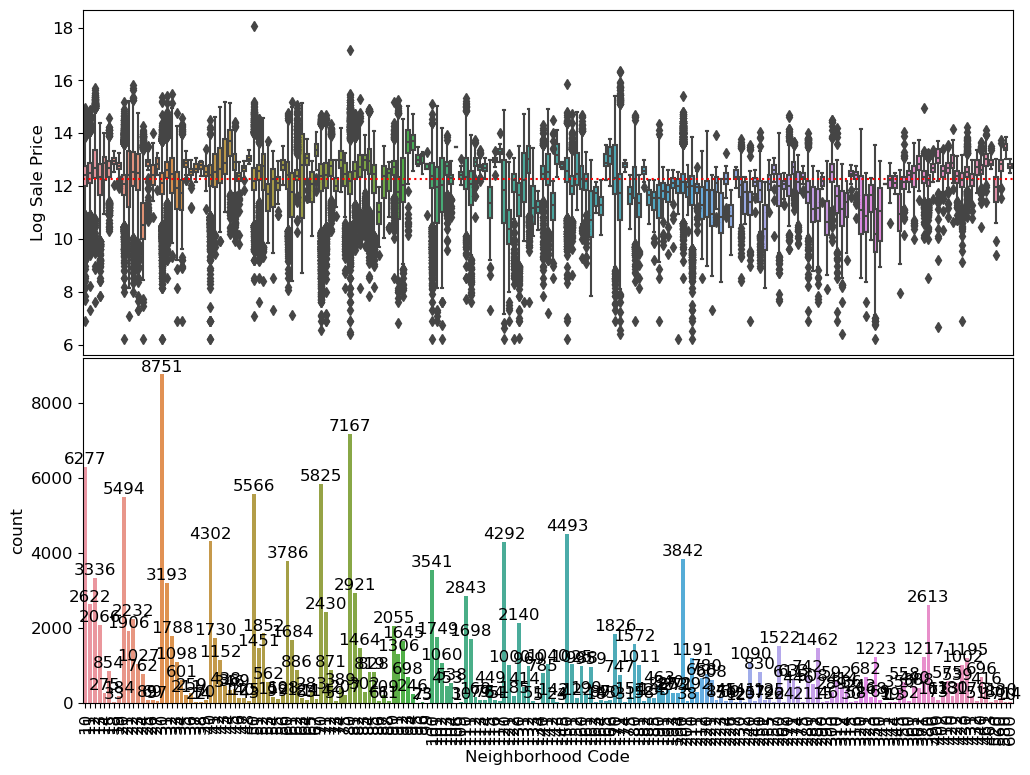

In [17]:
def plot_categorical(neighborhoods):
    fig, axs = plt.subplots(nrows=2)

    sns.boxplot(
        x='Neighborhood Code',
        y='Log Sale Price',
        data=neighborhoods,
        ax=axs[0],
    )

    sns.countplot(
        x='Neighborhood Code',
        data=neighborhoods,
        ax=axs[1],
    )

    # Draw median price
    axs[0].axhline(
        y=training_data['Log Sale Price'].median(), 
        color='red',
        linestyle='dotted'
    )

    # Label the bars with counts
    for patch in axs[1].patches:
        x = patch.get_bbox().get_points()[:, 0]
        y = patch.get_bbox().get_points()[1, 1]
        axs[1].annotate(f'{int(y)}', (x.mean(), y), ha='center', va='bottom')

    # Format x-axes
    axs[1].set_xticklabels(axs[1].xaxis.get_majorticklabels(), rotation=90)
    axs[0].xaxis.set_visible(False)

    # Narrow the gap between the plots
    plt.subplots_adjust(hspace=0.01)

plot_categorical(training_data)

Oh no, looks like we have run into the problem of overplotting again! 

You might have noticed that the graph is overplotted because **there are actually quite a few neighborhoods in our dataset**! For the clarity of our visualization, we will have to zoom in again on a few of them. The reason for this is our visualization will become quite cluttered with a super dense x-axis.

Let's create `in_top_20_neighborhoods`, a copy of `training_data` that has been filtered to only contain rows corresponding to properties that are in one of the top 20 most populous neighborhoods. We define the top 20 neighborhoods as being the 20 neighborhood codes that have the greatest number of properties within them.

In [18]:
top_20_neighborhood_codes = training_data["Neighborhood Code"].value_counts().head(20).index.tolist()
in_top_20_neighborhoods = training_data[training_data["Neighborhood Code"].isin(top_20_neighborhood_codes)]
in_top_20_neighborhoods

,PIN,Property Class,Neighborhood Code,Land Square Feet,Town Code,Apartments,Wall Material,Roof Material,Basement,Basement Finish,...,Age Decade,Pure Market Filter,Garage Indicator,Neigborhood Code (mapping),Town and Neighborhood,Description,Lot Size,Log Sale Price,Log Building Square Feet,Bedrooms
1,13272240180000,202,120,3780.0,71,0.0,2.0,1.0,1.0,1.0,...,9.6,1,1.0,120,71120,"This property, sold on 05/23/2018, is a one-st...",3780.0,12.560244,6.904751,3
4,31361040550000,202,120,8400.0,32,0.0,3.0,1.0,2.0,3.0,...,6.3,1,1.0,120,32120,"This property, sold on 06/10/2016, is a one-st...",8400.0,10.025705,6.855409,2
8,13232040260000,205,70,3100.0,71,0.0,2.0,2.0,1.0,3.0,...,10.0,1,1.0,70,7170,"This property, sold on 08/25/2016, is a two-st...",3100.0,13.422468,7.636270,4
10,19074270080000,202,380,3750.0,72,0.0,1.0,1.0,2.0,3.0,...,7.4,1,1.0,380,72380,"This property, sold on 05/01/2017, is a one-st...",3750.0,11.695247,6.841615,2
11,15083050330000,203,20,5092.0,31,0.0,2.0,1.0,1.0,1.0,...,5.8,1,1.0,20,3120,"This property, sold on 04/29/2014, is a one-st...",5092.0,11.184421,6.911747,3
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
204781,20361190390000,203,80,4405.0,70,0.0,2.0,1.0,1.0,3.0,...,5.7,1,1.0,80,7080,"This property, sold on 07/15/2013, is a one-st...",4405.0,10.913269,7.141245,3
204785,9284030280000,202,40,6650.0,22,0.0,1.0,1.0,1.0,3.0,...,6.1,1,1.0,40,2240,"This property, sold on 04/03/2014, is a one-st...",6650.0,11.736069,6.761573,3
204786,8141120110000,203,100,10010.0,16,0.0,2.0,1.0,1.0,1.0,...,5.6,1,1.0,100,16100,"This property, sold on 09/08/2016, is a one-st...",10010.0,12.568978,6.948897,3
204790,9242030500000,203,80,6650.0,22,0.0,2.0,1.0,1.0,3.0,...,6.0,1,1.0,80,2280,"This property, sold on 02/22/2018, is a one-st...",6650.0,12.879017,7.092574,3


Let's create another of the distribution of sale price within in each neighborhood again, but this time with a narrower focus!

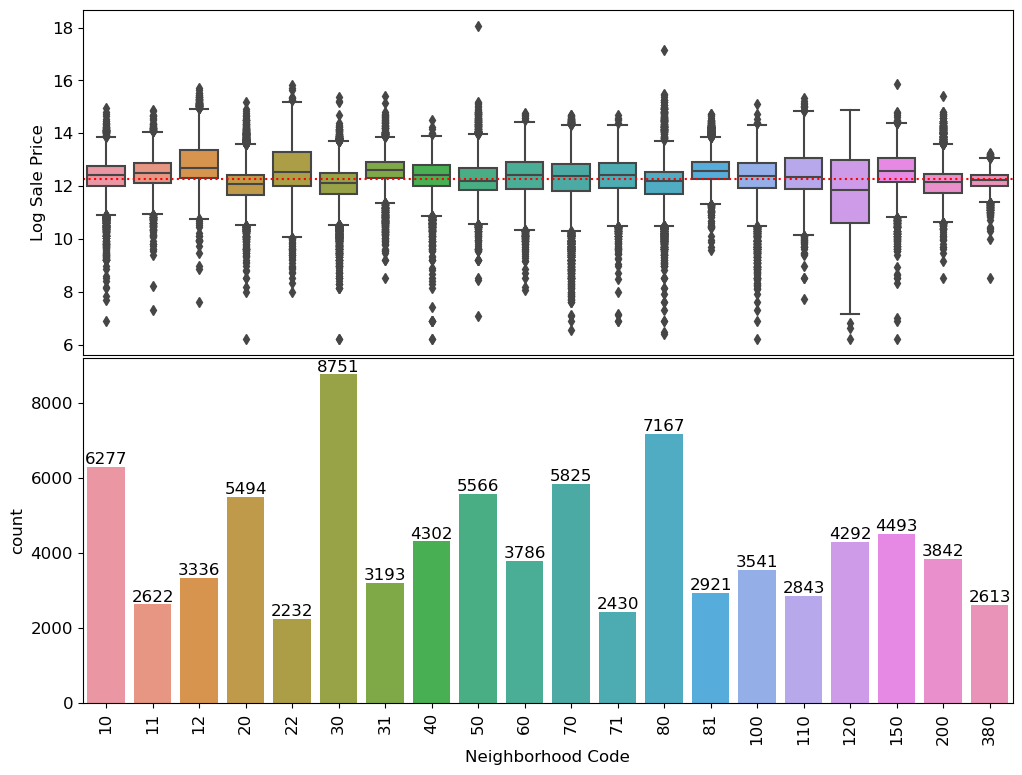

In [19]:
plot_categorical(neighborhoods=in_top_20_neighborhoods)

<br><br>

---

From the plot above, we can see that there is much less data available for some neighborhoods. For example, Neighborhood 71 has only around 27% of the number of datapoints as Neighborhood 30.

One way we can deal with the lack of data from some neighborhoods is to create a new feature that bins neighborhoods together. We’ll categorize our neighborhoods in a crude way. In this question, we’ll compute how “expensive” each neighborhood is by aggregating the `Log Sale Price`s for all properties in a particular neighborhood using a `metric`, such as the median. We’ll use this `metric` to find the top `n` most expensive neighborhoods. Later, we’ll label these “expensive neighborhoods” and leave all other neighborhoods unmarked.

Fill in `find_expensive_neighborhoods` to return a **list** of the neighborhood codes of the **top `n`** most expensive neighborhoods as measured by our choice of `metric`.

For example, calling `find_expensive_neighborhoods(training_data, n=3, metric=np.median)` should return the 3 neighborhood codes with the highest median `Log Sale Price` computed across all properties in those neighborhood codes. 

In [20]:
def find_expensive_neighborhoods(data, n=3, metric=np.median):
    """
    Input:
      data (DataFrame): should contain at least an int-valued 'Neighborhood Code'
        and a numeric 'Log Sale Price' column
      n (int): the number of top values desired
      metric (function): function used for aggregating the data in each neighborhood.
        for example, np.median for median prices
    
    Output:
      a list of the the neighborhood codes of the top n highest-priced neighborhoods 
      as measured by the metric function
    """
    neighborhoods = data[["Neighborhood Code", "Log Sale Price"]].groupby("Neighborhood Code").agg(metric)
    sorted = neighborhoods.sort_values("Log Sale Price", ascending = False)
    neighborhoods = sorted.head(n).index.tolist()
    
    # This makes sure the final list contains the generic int type used in Python3, not specific ones used in NumPy.
    return [int(code) for code in neighborhoods]

expensive_neighborhoods = find_expensive_neighborhoods(training_data, 3, np.median)
expensive_neighborhoods

[44, 94, 93]

<br><br>

---

We now have a list of neighborhoods we've deemed as higher-priced than others.  Let's use that information to write an additional function `add_expensive_neighborhood` that takes in a `DataFrame` of housing data (`data`) and a list of neighborhood codes considered to be expensive (`expensive_neighborhoods`). You can think of `expensive_neighborhoods` as being the output of the function `find_expensive_neighborhoods`. 

Using these inputs, `add_expensive_neighborhood` should add a column to `data` named `in_expensive_neighborhood` that takes on the **integer** value of 1 if a property is part of a neighborhood in `expensive_neighborhoods` and the integer value of 0 if it is not. This type of variable is known as an **indicator variable**.

In [21]:
def add_in_expensive_neighborhood(data, expensive_neighborhoods):
    """
    Input:
      data (DataFrame): a DataFrame containing a 'Neighborhood Code' column with values
        found in the codebook
      expensive_neighborhoods (list of ints): ints should be the neighborhood codes of
        neighborhoods pre-identified as expensive
    Output:
      DataFrame identical to the input with the addition of a binary
      in_expensive_neighborhood column
    """
    data['in_expensive_neighborhood'] = data['Neighborhood Code'].isin(expensive_neighborhoods).astype("int")
    return data

expensive_neighborhoods = find_expensive_neighborhoods(training_data, 3, np.median)
training_data = add_in_expensive_neighborhood(training_data, expensive_neighborhoods)

Let's take a closer look at the `Roof Material` feature of the dataset and examine how we can incorporate categorical features into our linear model.

<br><br>

---

If we look at `codebook.txt` carefully, we can see that the Assessor's Office uses the following mapping for the numerical values in the `Roof Material` column.
```
Roof Material (Nominal): 

       1    Shingle/Asphalt
       2    Tar & Gravel
       3    Slate
       4    Shake
       5    Tile
       6    Other
```

We defined the function `substitute_roof_material` which replaces each numerical value in `Roof Material` with their corresponding roof material. The function returns a new `DataFrame`, and doesn't modify the existing `DataFrame`.

In [22]:
def substitute_roof_material(data):
    """
    Input:
      data (DataFrame): a DataFrame containing a 'Roof Material' column.  Its values
                         should be limited to those found in the codebook
    Output:
      new DataFrame identical to the input except with a refactored 'Roof Material' column
    """
    new_data = data.copy()
    new_data = new_data.replace({"Roof Material":{1.0:"Shingle/Asphalt", 2.0:"Tar & Gravel", 3.0:"Slate", 4.0:"Shake", 5.0:"Tile", 6:"Other"}})
    return new_data
    
training_data_mapped = substitute_roof_material(training_data)
training_data_mapped.head()

,PIN,Property Class,Neighborhood Code,Land Square Feet,Town Code,Apartments,Wall Material,Roof Material,Basement,Basement Finish,...,Pure Market Filter,Garage Indicator,Neigborhood Code (mapping),Town and Neighborhood,Description,Lot Size,Log Sale Price,Log Building Square Feet,Bedrooms,in_expensive_neighborhood
1,13272240180000,202,120,3780.0,71,0.0,2.0,Shingle/Asphalt,1.0,1.0,...,1,1.0,120,71120,"This property, sold on 05/23/2018, is a one-st...",3780.0,12.560244,6.904751,3,0
2,25221150230000,202,210,4375.0,70,0.0,2.0,Shingle/Asphalt,2.0,3.0,...,1,1.0,210,70210,"This property, sold on 02/18/2016, is a one-st...",4375.0,9.998798,6.810142,3,0
3,10251130030000,203,220,4375.0,17,0.0,3.0,Shingle/Asphalt,1.0,3.0,...,1,1.0,220,17220,"This property, sold on 07/23/2013, is a one-st...",4375.0,12.323856,7.068172,3,0
4,31361040550000,202,120,8400.0,32,0.0,3.0,Shingle/Asphalt,2.0,3.0,...,1,1.0,120,32120,"This property, sold on 06/10/2016, is a one-st...",8400.0,10.025705,6.855409,2,0
6,30314240080000,203,181,10890.0,37,0.0,1.0,Shingle/Asphalt,1.0,3.0,...,1,1.0,181,37181,"This property, sold on 10/26/2017, is a one-st...",10890.0,11.512925,7.458186,4,0


<br><br>

---

#### An Important Note on One-Hot-Encoding 

Unfortunately, simply replacing the integers with the appropriate strings isn’t sufficient for using `Roof Material` in our model.  Since `Roof Material` is a categorical variable, we will have to one-hot-encode the data. For more information on why we want to use one-hot-encoding.

The function `ohe_roof_material` returns a `DataFrame` with the new column one-hot-encoded on the roof material of the household. These new columns have the form `Roof Material_MATERIAL`, returning a new `DataFrame`. 

Here, we use `scikit-learn`’s `OneHotEncoder` to perform the one-hot-encoding. `OneHotEncoder` will automatically generate column names of the form `Roof Material_MATERIAL`. We wish to construct the one-hot-encoding columns **without removing any columns**.

In [23]:
from sklearn.preprocessing import OneHotEncoder

def ohe_roof_material(data):
    """
    One-hot-encodes roof material. New columns are of the form "Roof Material_MATERIAL".
    """
    column = ["Roof Material"]

    encoder = OneHotEncoder()
    fitted = encoder.fit(data[column])
    transformed = fitted.transform(data[column]).toarray()

    transformed_df = pd.DataFrame(data = transformed, columns = encoder.get_feature_names_out(), index = data.index)
    final = data.join(transformed_df)
    return final

training_data_ohe = ohe_roof_material(training_data_mapped)
# This line of code will display only the one-hot-encoded columns in training_data_ohe that 
# have names that begin with “Roof Material_" 
training_data_ohe.filter(regex='^Roof Material_').head(10)

,Roof Material_Other,Roof Material_Shake,Roof Material_Shingle/Asphalt,Roof Material_Slate,Roof Material_Tar & Gravel,Roof Material_Tile
1,0.0,0.0,1.0,0.0,0.0,0.0
2,0.0,0.0,1.0,0.0,0.0,0.0
3,0.0,0.0,1.0,0.0,0.0,0.0
4,0.0,0.0,1.0,0.0,0.0,0.0
6,0.0,0.0,1.0,0.0,0.0,0.0
7,0.0,0.0,1.0,0.0,0.0,0.0
8,0.0,0.0,0.0,0.0,1.0,0.0
9,0.0,0.0,1.0,0.0,0.0,0.0
10,0.0,0.0,1.0,0.0,0.0,0.0
11,0.0,0.0,1.0,0.0,0.0,0.0


#### Now let's focus on building a linear regression model to predict house prices!